In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from qmlbo import signals

In [10]:
def hat_weights_bias2_var(n_0, n, m, c, sigma, power):
    """Compute the bias^2 and variance for hat weights explicitly.
    
    Note that `c` here refers to the scale of _nu_, the weights will scale as sqrt(c).
    """
    d = n * (m + 1)
    bias_num = power * n_0**2 * (m + 1) * m
    bias_denom = c * (d - n_0) / (1 - c) + m * n_0 
    bias2 = bias_num / bias_denom ** 2
    
    var_first_num = n_0 * ( (c / n_0)**2 + m * ( (1 - c)/(d - n_0) ) ** 2 )
    var_first_denom = c/ n_0 + m * (1-c)/(d-n_0)
    var_second = (n - n_0) / (m + 1)
    var = (sigma ** 2 / n) * (var_first_num / var_first_denom ** 2 + var_second ) 
    
    return bias2, var

### Generate data for Figure 3

In [5]:
# Plot error behavior as a function of d for fixed n
n_0 = 15 # size of the signal band
SIGMA_SQ = 0.4
SIGMA = np.sqrt(SIGMA_SQ)
POWER = 0.6
n_fixed = 31
SIGNAL_FOURIER_COEFFICIENTS = np.ones(n_0) * np.sqrt(POWER / n_0)
dim_arr = np.arange(n_0+2, 601, 2)


In [6]:
n_arr = np.arange(17, 10001, 10)

m_arr_lst = [
    (r"$d\sim n$", 2 * np.ones_like(n_arr)), # linear, odd dimensions
    (r"$d\sim n^{1.33}$", 2 * (n_arr ** 0.33)),
    (r"$d\sim n^2$", 2 * n_arr),
]
weights_lst = []
assert min(n_arr) >= n_0

# Gather experimental and analyitical error terms for the model
# first dimension is indexed as 0=bias^2, 1=var, 2=total
ana_errors = np.zeros((2, len(n_arr), len(m_arr_lst)))

hat_c = 0.8

for k, (_, m_arr) in enumerate(m_arr_lst):
    for j, (n, m) in enumerate(zip(n_arr, m_arr)):

        d = n * (m + 1)
        bias2, var = hat_weights_bias2_var(n_0, n, m, hat_c, SIGMA, POWER)
        ana_errors[0,j,k] = bias2
        ana_errors[1,j,k] = var    

In [7]:
def signal(times, sigma):
    return signals.signal_from_fourier_coefficients(times, fcoeffs=SIGNAL_FOURIER_COEFFICIENTS, sigma=sigma)

# Run an "experiment" with `n` time samples
time_samples = np.linspace(0, 1-1/n_fixed, n_fixed) # this gives dx = 1/n. i.e. x = (0, 1/n, ..., (n-1)/n)
M = 90
timesteps = M * n_fixed
time_continuous = np.linspace(0, 1, timesteps)
noiseless_f_sampled = signal(time_samples, sigma=0) # noiseless samples

demo_c = 0.7

fixed_n_ana_errors = np.zeros((2, len(dim_arr)))

for j, d in enumerate(dim_arr):

    f_cont = signal(time_continuous, sigma=0) # noiseless, continuous

    # Set the weights
    weights = signals.hat_weights(n_0, d, pair=[np.sqrt(demo_c / n_0), np.sqrt((1 - demo_c)/(d - n_0))], normalize=False)
    
    # analytical error is independent of random noise
    bias2, var = signals.compute_bias2_var(noiseless_f_sampled, weights, SIGMA)
    fixed_n_ana_errors[0, j] = bias2
    fixed_n_ana_errors[1, j] = var

### Plot Figure 3

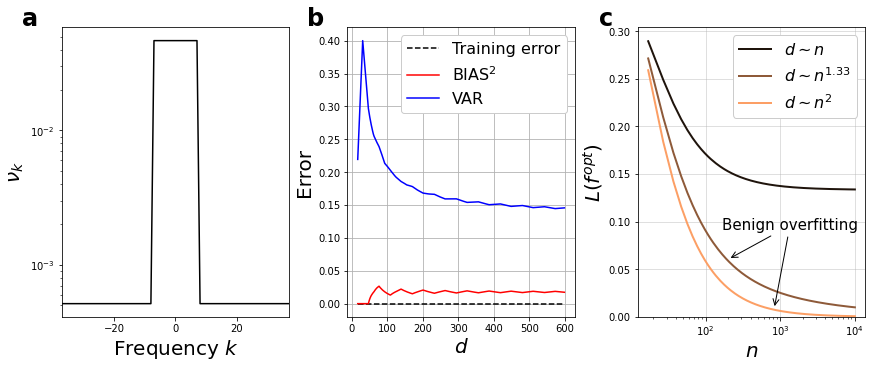

In [8]:
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

xlab_size = 20
ylab_size = 20

# Panel a: demo the weights 
demo_weights = signals.hat_weights(n_0, 75, pair=[np.sqrt(demo_c/n_0), np.sqrt((1 - demo_c)/(d - n_0))], normalize=False)
demo_d = len(demo_weights)
demo_freqs = np.arange(-(demo_d - 1)//2, (demo_d + 1)//2, 1)
ax0.plot(demo_freqs, demo_weights ** 2, c='k')
ax0.set_xlabel(r"Frequency $k$", size=xlab_size)
ax0.set_ylabel(r"$\nu_k$", size=ylab_size)
ax0.set_xlim(min(demo_freqs), max(demo_freqs))
ax0.semilogy()


# Panel b: Plot generalization error breakdown for a fixed n setting
ax1.plot(dim_arr, np.zeros_like(dim_arr), label=r"Training error", ls='--', c='k', lw=1.5)
ax1.plot(dim_arr, fixed_n_ana_errors[0,:], label=r"BIAS$^2$", ls='-', c='r', lw=1.5)
ax1.plot(dim_arr, fixed_n_ana_errors[1,:], label=r"VAR", ls='-', c='b', lw=1.5)

ax1.grid()
ax1.legend(loc='best', ncol=1, prop={'size': 16}, framealpha=1)
ax1.set_ylim(-0.02, ax1.get_ylim()[1])
ax1.set_xlabel(r"$d$", size=xlab_size)
ax1.set_ylabel("Error", size=ylab_size)

# Panel c: demonstrate B.O. with different d scalings
number_of_lines= 3
cm_subsection = np.linspace(0.1, 0.8, number_of_lines) 
colors = [ cm.copper(x) for x in cm_subsection ]

arrow_locs = []
for k, (label, m_arr) in enumerate(m_arr_lst):
    d_arr = np.multiply(n_arr, m_arr + 1)
    yvals = ana_errors[:2,:,k].sum(axis=0)
    ax2.plot(n_arr, yvals, label=label, ls='-', color=colors[k], lw=2)

    if k >= 1:
        idx = len(n_arr)//8
        arrow_locs.append((n_arr[idx] , yvals[idx] ))

ax2.legend(loc='best', ncol=1, prop={'size': 16}, framealpha=1)
ax2.set_xlabel(r"$n$", size=xlab_size)
ax2.set_ylabel(r"$L(f^{opt})$", size=ylab_size)
ax2.grid(alpha=0.5)
ax2.set_ylim(0, ax2.get_ylim()[1])

# Panel c annotations
xytext = (0.37, 0.3)
ax2.annotate("Benign overfitting", xy=(0.4, 0.2), xytext=xytext, xycoords='axes fraction', arrowprops=dict(arrowstyle="->", color='k'), fontsize=15)
ax2.annotate("Benign overfitting", xy=(0.6, 0.03), xytext=xytext, xycoords='axes fraction', arrowprops=dict(arrowstyle="->", color='k'), fontsize=15, alpha=0)
ax2.semilogx()

# panel annotations
ax0.text(-0.14, 1.03, r"a", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=ax0.transAxes, weight="bold")
ax1.text(-0.14, 1.03, r"b", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=ax1.transAxes, weight="bold")
ax2.text(-0.14, 1.03, r"c", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=ax2.transAxes, weight="bold")

fig.savefig("../figures/figure3.pdf", bbox_inches='tight')

### (Appendix A.2.1) Verify closed form expressions for hat weight error

In [9]:
def test_hat_weight_error():
    
    n_0 = 5
    c = 0.2  
    n = 7
    m = 4
    d = n * (m + 1)
    sigma = 0.4
    power = 0.3
    
    time_samples = np.linspace(0, 1-1/n, n)
    fcoeffs = [1, 2, 3, 2, 1]
    fcoeffs = fcoeffs / np.linalg.norm(fcoeffs, ord=2) * np.sqrt(power)
    assert len(fcoeffs) == n_0
    
    weights = signals.hat_weights(n_0, d, pair=[np.sqrt(c/n_0), np.sqrt((1 - c)/(d - n_0))], normalize=False)
    sampled = signals.signal_from_fourier_coefficients(time_samples, fcoeffs=fcoeffs, sigma=0)
    
    bias2, var = signals.compute_bias2_var(sampled, weights, sigma)
    bias2_new, var_new = hat_weights_bias2_var(n_0, n, m, c, sigma, power)
    
    np.testing.assert_allclose(bias2, bias2_new)
    np.testing.assert_allclose(var, var_new)
    
test_hat_weight_error()